In [1]:
import os, sys, csv
from datetime import datetime 
import itertools
import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

%matplotlib inline 

In [15]:
data_dir = '/data4/u5790670/citation_network/static/flow'
venue_name = 'ICML'
# venue_name = 'Optics Letters'
# venue_name = 'Optics Express'
# venue_name = 'Nature Photonics'

venue_name = venue_name.replace(' ', '_')

file_name = 'citing_flow_edge.'+venue_name+'.2000_2016.csv'
file_path = os.path.join(data_dir, file_name)

# old reading code: only one weight for each edge
# with open(file_path, 'rb') as f:
#     next(f)   # skip a line
#     G = nx.read_edgelist(f, delimiter=';', nodetype=str, data=(('weight',float),))

# new reading code: with bidirection of each edge with different weights
G = nx.DiGraph()
with open(file_path, 'r') as f:
    next(f)   # skip a line
    edge_reader = csv.reader(f, delimiter=';')
    for row in edge_reader:
        G.add_edge(row[0], row[1], weight=float(row[2]))
        


In [30]:
# nx.draw(G)
# H = G.to_directed()
print(G.in_edges('australian national university')[:5])
print(G.out_edges('australian national university')[:5])

[('ibm', 'australian national university'), ('university of texas at austin', 'australian national university'), ('new york university', 'australian national university'), ('ohio state university', 'australian national university'), ('tufts university', 'australian national university')]
[('australian national university', 'hewlett packard'), ('australian national university', 'university of washington'), ('australian national university', 'ibm'), ('australian national university', 'carnegie mellon university'), ('australian national university', 'microsoft')]


In [14]:
# goal 1 -- draw half-circle of incoming/outgoing curved edges
def draw_halfcircle(graph=None, ego=None, ax=None, direction="out", renorm_weights='lin', venue_name='', max_neighbour = 20,
                   plot_setting={'max_marker':30, 'max_line': 10., 'min_line': .5, 
                                 "sns_palette": "RdBu", "out_palette": "OrRd", "in_palette": "GnBu", 
                                 "num_colors": 100, "delta_text":0.02}):
    ps = plot_setting
    if not ax:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111)
    sns.set_context("talk", font_scale=1.)
    sns.set_style("white")
    sns.despine()
        
    xroot = 0.
    yroot = 0.
    ax.plot(xroot, yroot, 'o', c=[.5, .5, .5], markersize=1.2*ps['max_marker'], fillstyle='full', mec='0.5')
    ax.text(xroot, yroot-5*ps['delta_text'], venue_name+'_'+ego, horizontalalignment='center')
    
    
    # take the subgraph out as a node list and a weight list
    if direction == "in":
        node_list = [e[0] for e in graph.in_edges(ego)]
        if ego in node_list:
            node_list.remove(ego)
        weight_list = [graph[n][ego]['weight'] for n in node_list]
        node_colors = sns.color_palette(ps['in_palette'], ps['num_colors']) #len(node_list))
        arrow_str = '->'
    else:
        node_list = [e[1] for e in graph.edges(ego)]
        if ego in node_list:
            node_list.remove(ego)
        weight_list = [graph[ego][n]['weight'] for n in node_list]
        node_colors = sns.color_palette(ps['out_palette'], ps['num_colors'])
        arrow_str = '<-'
    
    nn = min(len(node_list), max_neighbour)
    edge_color = node_colors[int(ps['num_colors']/2)]
    all_edge_weight = [d['weight'] for (u,v,d) in G.edges(data=True)]
    
    # nomalise these weights to get edge width
    if renorm_weights == 'log':
        weight_max = max( [np.log10(w+1) for w in all_edge_weight])
        weight_min = min( [np.log10(w+1) for w in all_edge_weight])
#         weight_max = max( [np.log10(w) for w in weight_list] )
#         weight_min = min( [np.log10(w) for w in weight_list] )
        weight_norm = [ (np.log10(w+1)-weight_min)/(weight_max-weight_min) for w in weight_list ]
    elif renorm_weights == 'lin':
        weight_max = max(all_edge_weight)
        weight_min = min(all_edge_weight)
#         weight_max = max(weight_list)
#         weight_min = min(weight_list)
        weight_norm = [ (w-weight_min)/(weight_max-weight_min) for w in weight_list ]
    # print(weight_norm, weight_max, weight_min, nn)
    
    # sort order of edges based on the weight 
    isort = np.argsort(weight_list)
    
    anglelist = np.linspace(np.pi, 0., num=nn)
    iangle = [i for i in range(0, nn, 2) ] + [i for i in range(nn - (nn+1)%2, 0, -2) ]
    #anglelist = anglelist[iangle]
    #print(iangle)
    
    for i, jn in enumerate(isort[-nn:]):
        n = node_list[jn]
        w = weight_norm[jn]
        # node position
        xp = np.cos(anglelist[i]) 
        yp = np.sin(np.abs(anglelist[i])) 
        #print((xp, yp))
        
        # calculate node color index based on its weight
        ci = int( w*(len(node_colors)-1e-3) )
        lw = ps['max_line'] * w + ps['min_line']
        # plot the node
        ax.plot(xp, yp, 'o', c=node_colors[ci], markersize= ps['max_marker'], # markersize=int(sz), 
            alpha=.9, mec='0.5', mew=.5) 
        # add node text 
        h = ax.text(xp, yp, n, horizontalalignment='left')
        # draw arc / arrow 
        ax.annotate("", xy=(xroot, yroot), xycoords='data',
            xytext=(xp, yp), textcoords='data',
            arrowprops=dict(arrowstyle = arrow_str, 
                        color=edge_color, linewidth = lw,
                        connectionstyle="arc3,rad=0.12", ), )
        
    ### TODO: draw color bar
    #cbar = plt.colorbar(cax = ax) #, ticks=[-1, 0, 1])
    #cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar
   
    ax.set_xlim((-1.2, 1.2))
    ax.set_ylim((-.1, 1.1))
    ax.axis('off')
    

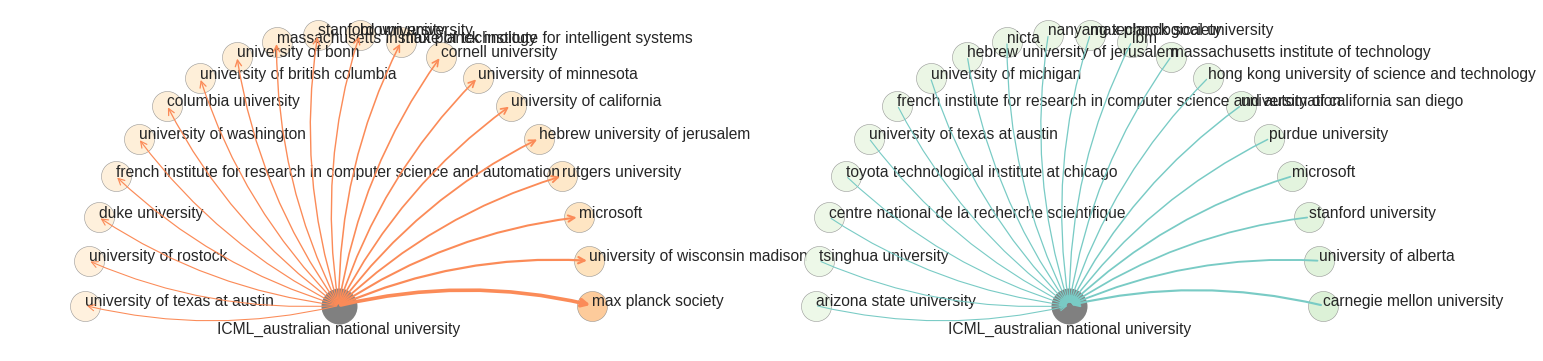

In [15]:
university_name = "australian national university"
# university_name = "stanford university"
# university_name = "max planck society"
# university_name = "university of sydney"
# university_name = "university of melbourne"
# university_name = "university of technology sydney"

fig = plt.figure(figsize=(24, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
draw_halfcircle(graph=G, ego=university_name, direction="out", ax=ax1, renorm_weights='log', venue_name=venue_name)
draw_halfcircle(graph=G, ego=university_name, direction="in" , ax=ax2, renorm_weights='log', venue_name=venue_name)

In [16]:
# goal 2 -- draw circle layout of incoming/outgoing curved edges plus other edges in the ego net
def draw_egocircle(graph=None, ego=None, ax=None, direction="out", renorm_weights='lin', venue_name='', max_neighbour = 20,
                   plot_setting={'max_marker':30, 'max_line': 25., 'min_line': .5, 'max_link': 3.,
                                 "sns_palette": "RdBu", "out_palette": "OrRd", "in_palette": "GnBu",
                                 "num_colors": 100, "delta_text":0.02}):
    ps = plot_setting
    if not ax:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111)
    sns.set_context("talk", font_scale=1.)
    sns.set_style("white")
    sns.despine()
        
    xroot = 0.
    yroot = 0.
    ax.plot(xroot, yroot, 'o', c=[.5, .5, .5], markersize=1.2*ps['max_marker'], fillstyle='full', mec='0.5')
    ax.text(xroot, yroot-5*ps['delta_text'], ego, horizontalalignment='center')
    
    
    # take the subgraph out as a node list and a weight list
    if direction == "in":
        node_list = [e[0] for e in graph.in_edges(ego)]
        if ego in node_list:
            node_list.remove(ego)
        weight_list = [graph[n][ego]['weight'] for n in node_list]
        node_colors = sns.color_palette(ps['in_palette'], ps['num_colors'])
        arrow_str = '->'
    else:
        node_list = [e[1] for e in graph.out_edges(ego)]
        if ego in node_list:
            node_list.remove(ego)
        weight_list = [graph[ego][n]['weight'] for n in node_list]
        node_colors = sns.color_palette(ps['out_palette'], ps['num_colors'])
        arrow_str = '<-'
#    print(weight_list)
    nn = min(len(node_list), max_neighbour)
    edge_color = node_colors[int(ps['num_colors']/2)]
    all_edge_weight = [d['weight'] for (u,v,d) in G.edges(data=True)]
    
    # nomalise these weights to get edge width
    if renorm_weights == 'log':
        weight_max = max( [np.log10(w+1) for w in all_edge_weight])
        weight_min = min( [np.log10(w+1) for w in all_edge_weight])
#         weight_max = max( [np.log10(w) for w in weight_list] )
#         weight_min = min( [np.log10(w) for w in weight_list] )
        weight_norm = [ (np.log10(w+1)-weight_min)/(weight_max-weight_min) for w in weight_list ]
    elif renorm_weights == 'lin':
        weight_max = max(all_edge_weight)
        weight_min = min(all_edge_weight)
#         weight_max = max(weight_list)
#         weight_min = min(weight_list)
        weight_norm = [ (w-weight_min)/(weight_max-weight_min) for w in weight_list ]
    #print(weight_norm, weight_max, weight_min, nn)
    
    # sort order of edges based on the weight 
    isort = np.argsort(weight_list)[::-1]
    
    anglelist = np.linspace(0.05, 0.9*np.pi, num=nn)
    #iangle = [i for i in range(0, nn, 2) ] + [i for i in range(nn - (nn+1)%2, 0, -2) ]
    #anglelist = anglelist[iangle]
    #print(iangle)
    node_pos = [()]* len(node_list)
    
    for i, jn in enumerate(isort[:nn]):
        w = weight_norm[jn]
        # node position
        xp = np.cos(anglelist[i]) + 1.
        yp = np.sin(np.abs(anglelist[i])) * ((-1)**(i%2))
        node_pos[jn] = (xp, yp)
        
        # calculate node color index based on its weight
        ci = int( w*(len(node_colors)-1e-3) )
        lw = ps['max_line'] * w + ps['min_line']
        # plot the node
        ax.plot(xp, yp, 'o', c=node_colors[ci], markersize= ps['max_marker'], # markersize=int(sz), 
            alpha=.9, mec='0.5', mew=.5) 
        
    

        
    # now draw the remaining edges of the ego net, between pairs of neighbours
    for i, j in itertools.permutations([i for i in isort[:nn]], r=2):
        # draw edge if exists
        if node_list[j] in graph[node_list[i]]:
            w = graph[node_list[i]][node_list[j]]['weight']
            lw = ps['max_link'] * w + ps['min_line']

            ax.annotate("", xy = node_pos[i], xycoords='data',
                xytext = node_pos[j], textcoords='data',
                arrowprops=dict(arrowstyle="-", #linestyle="dashed",
                                color = (.5, .5, .5), linewidth= lw,
                                connectionstyle="arc3,rad=0.12", ), )
    
    # draw arc / arrow
    for i, jn in enumerate(isort[:nn]):
        n = node_list[jn]
        w = weight_norm[jn]
        # node position
        xp = np.cos(anglelist[i]) + 1.
        yp = np.sin(np.abs(anglelist[i])) * ((-1)**(i%2))
        
        ci = int( w*(len(node_colors)-1e-3) )
        lw = ps['max_line'] * w + ps['min_line']
        ax.annotate("", xy=(xroot, yroot), xycoords='data',
            xytext=(xp, yp), textcoords='data',
            arrowprops=dict(arrowstyle = arrow_str, 
                        color=edge_color, linewidth = lw,
                        connectionstyle="arc3,rad=0.12", ), )
        # add node text 
        h = ax.text(xp, yp, n, horizontalalignment='left')
        
    # TODO: colorbar scale
    #cbar = plt.colorbar(cax = ax) #, ticks=[-1, 0, 1])
    #cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar
   
    ax.set_xlim((-.2, 2.2))
    ax.set_ylim((-1.1, 1.1))
    ax.axis('off')
    ax.title.set_text(venue_name+'_'+university_name+"_"+direction)
    

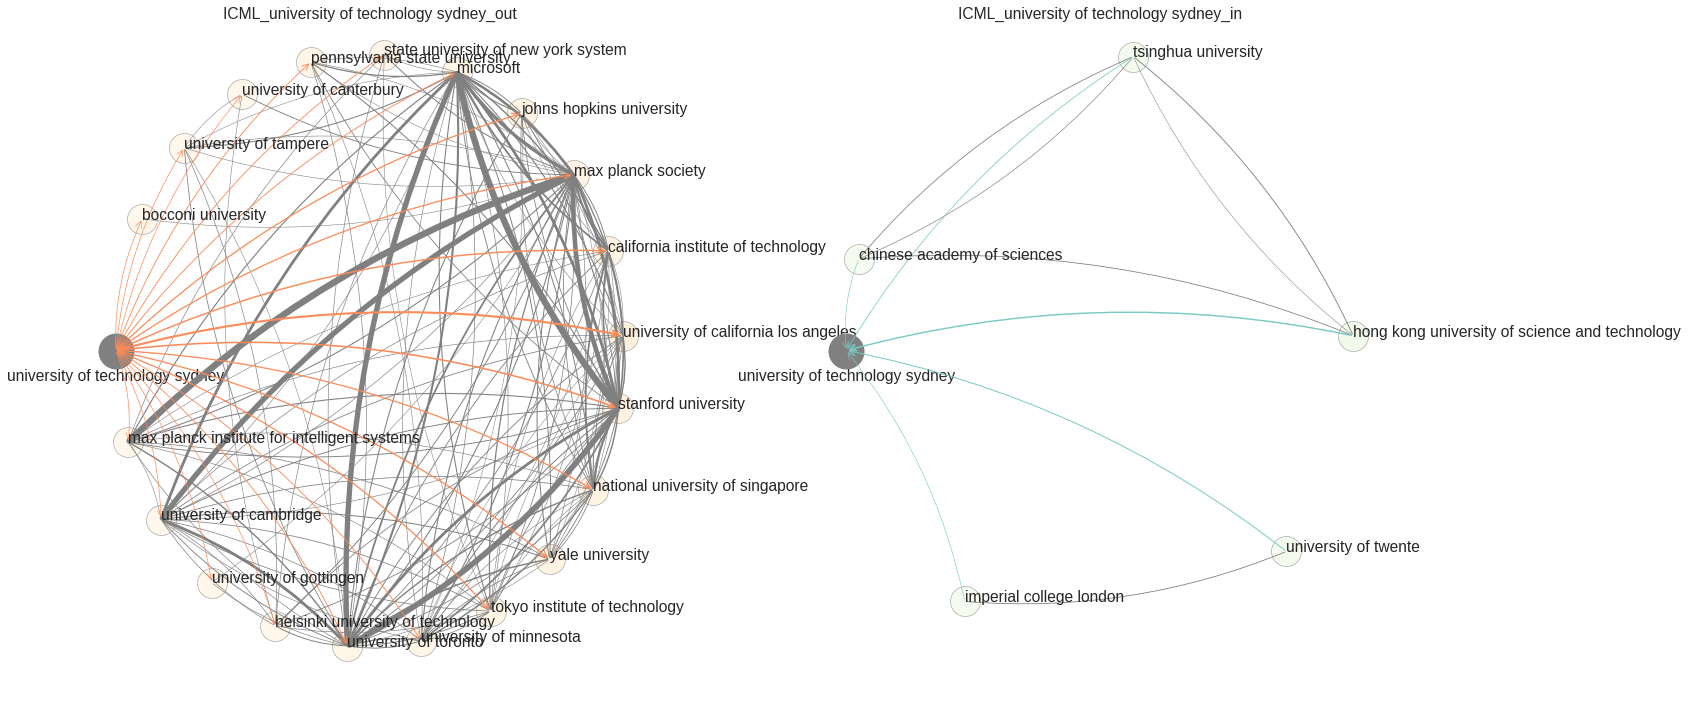

In [17]:
# university_name = "australian national university"
# university_name = "stanford university"
# university_name = "max planck society"
# university_name = "university of sydney"
# university_name = "university of melbourne"
university_name = "university of technology sydney"
fig = plt.figure(figsize=(24, 12))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
draw_egocircle(graph=G, ego=university_name, direction="out", ax=ax1, renorm_weights='log', venue_name=venue_name)
draw_egocircle(graph=G, ego=university_name, direction="in" , ax=ax2, renorm_weights='log', venue_name=venue_name)


# New Circle Layout

In [7]:
# goal 3 -- draw circle layout of incoming/outgoing curved edges plus other edges in the ego net
def draw_egocircle_inout(graph=None, ego=None, ax=None, direction="out", renorm_weights='lin', venue_name='', 
                   max_neighbour = 20, solid=False,
                   plot_setting={'max_marker':30, 'max_line': 25., 'min_line': .5, 'max_link': 3.,
                                 "sns_palette": "RdBu", "out_palette": "OrRd", "in_palette": "GnBu",
                                 "num_colors": 100, "delta_text":0.02}):
    ps = plot_setting
    if not ax:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111)
    sns.set_context("talk", font_scale=1.)
    sns.set_style("white")
    sns.despine()
        
    xroot = 0.
    yroot = 0.

    node_list = graph.nodes()
    in_node_list = set([e[0] for e in graph.in_edges(ego)])
    out_node_list = set([e[1] for e in graph.out_edges(ego)])
    
    if ego in node_list:
        node_list.remove(ego)
        
    all_edge_weight = [d['weight'] for (u,v,d) in G.edges(data=True)]
    weight_max = max( [np.log10(w+1) for w in all_edge_weight])
    weight_min = min( [np.log10(w+1) for w in all_edge_weight])
    
    in_weight_map = dict({(n, graph[n][ego]['weight']) if n in in_node_list else (n, 0) for n in node_list})
    out_weight_map = dict({(n, graph[ego][n]['weight']) if n in out_node_list else (n, 0) for n in node_list})
    for k, w in in_weight_map.items():
        in_weight_map[k] = (np.log10(w+1)-weight_min)/(weight_max-weight_min)
    for k, w in out_weight_map.items():
        out_weight_map[k] = (np.log10(w+1)-weight_min)/(weight_max-weight_min)
        
    top_in_node_list = [x[0] for x in sorted(in_weight_map.items(), key=lambda t: t[1], reverse=True)[:max_neighbour]]
    top_out_node_list = [x[0] for x in sorted(out_weight_map.items(), key=lambda t: t[1], reverse=True)[:max_neighbour]]
    top_whole_node_list = list(set(top_in_node_list) | set(top_out_node_list))
#     print(top_whole_node_list, len(top_whole_node_list))

    ratio_weight_map = dict((n, in_weight_map[n] - out_weight_map[n]) for n in top_whole_node_list)
    top_whole_node_list = [x[0] for x in sorted(ratio_weight_map.items(), key=lambda t: t[1], reverse=True)]
    
    nn = len(top_whole_node_list)
    
#     #print(weight_norm, weight_max, weight_min, nn)
    in_node_colors = sns.color_palette(ps['in_palette'], ps['num_colors'])
    out_node_colors = sns.color_palette(ps['out_palette'], ps['num_colors'])
    in_edge_color = in_node_colors[int(ps['num_colors']/2)]
    out_edge_color = out_node_colors[int(ps['num_colors']/2)]
    
    node_colors = in_node_colors
    anglelist = np.linspace(0.95*np.pi, 0.05*np.pi,  num=nn)
    node_pos = [()]* len(node_list)
    for i in range(nn):
        jn = top_whole_node_list[i]
        w = in_weight_map[jn]
        # node position
        xp = np.sin(np.abs(anglelist[i])) * ((-1)**(i%2))
        yp = np.cos(anglelist[i])
        node_pos[i] = (xp, yp)
        
        # calculate node color index based on its weight
        ci = int( w*(len(node_colors)-1e-3) )
        lw = ps['max_line'] * w + ps['min_line']
        # plot the node
        ax.plot(xp, yp, 'o', c=node_colors[ci], markersize= ps['max_marker'], # markersize=int(sz), 
            alpha=.9, mec='0.5', mew=.5) 
        
    for i in range(nn):
        jn = top_whole_node_list[i]
        in_w = in_weight_map[jn]
        out_w = out_weight_map[jn]
        # node position
        xp = np.sin(np.abs(anglelist[i])) * ((-1)**(i%2))
        yp = np.cos(anglelist[i])

        in_ci = int( in_w*(len(in_node_colors)-1e-3) )
        out_ci = int( out_w*(len(out_node_colors)-1e-3) )
        in_lw = ps['max_line'] * in_w + ps['min_line']
        out_lw = ps['max_line'] * out_w + ps['min_line']
        ax.annotate("", xy=(xroot, yroot), xycoords='data',
            xytext=(xp, yp), textcoords='data',
            arrowprops=dict(arrowstyle = '<-', 
                        color=in_edge_color, linewidth = in_lw,
                        connectionstyle="arc3,rad=0.2", ), )
        ax.annotate("", xy=(xp, yp), xycoords='data',
            xytext=(xroot, yroot), textcoords='data',
            arrowprops=dict(arrowstyle = '<-', 
                        color=out_edge_color, linewidth = out_lw,
                        connectionstyle="arc3,rad=0.2", ), )
        
        # add node text
        h = ax.text(xp, yp, jn, horizontalalignment=['left', 'right'][i%2], color=node_colors[-1])
        
    ax.plot(xroot, yroot, 'o', c=[.5, .5, .5], markersize=1.2*ps['max_marker'], fillstyle='full', mec='0.5')
    ax.text(xroot, yroot-5*ps['delta_text'], ego, horizontalalignment='center')

    ax.set_xlim((-1.2, 1.2))
    ax.set_ylim((-1.2, 1.2))
    ax.axis('off')
    ax.title.set_text("Influence Flower: " + venue_name+'_'+university_name)
    

In [8]:
# goal 4 -- draw solid circle with edges in the ego net
def draw_egocircle_solid(graph=None, ego=None, ax=None, direction="out", renorm_weights='lin', venue_name='', 
                   max_neighbour = 20, solid=False,
                   plot_setting={'max_marker':30, 'max_line': 25., 'min_line': .5, 'max_link': 3.,
                                 "sns_palette": "RdBu", "out_palette": "OrRd", "in_palette": "GnBu",
                                 "num_colors": 100, "delta_text":0.02}):
    ps = plot_setting
    if not ax:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111)
    sns.set_context("talk", font_scale=1.)
    sns.set_style("white")
    sns.despine()
        
    xroot = 0.
    yroot = 0.

    node_list = graph.nodes()
    in_node_list = set([e[0] for e in graph.in_edges(ego)])
    out_node_list = set([e[1] for e in graph.out_edges(ego)])
    
    if ego in node_list:
        node_list.remove(ego)
        
    all_edge_weight = [d['weight'] for (u,v,d) in G.edges(data=True)]
    weight_max = max( [np.log10(w+1) for w in all_edge_weight])
    weight_min = min( [np.log10(w+1) for w in all_edge_weight])
    
    in_weight_map = dict({(n, graph[n][ego]['weight']) if n in in_node_list else (n, 0) for n in node_list})
    out_weight_map = dict({(n, graph[ego][n]['weight']) if n in out_node_list else (n, 0) for n in node_list})
    for k, w in in_weight_map.items():
        in_weight_map[k] = (np.log10(w+1)-weight_min)/(weight_max-weight_min)
    for k, w in out_weight_map.items():
        out_weight_map[k] = (np.log10(w+1)-weight_min)/(weight_max-weight_min)
        
    top_in_node_list = [x[0] for x in sorted(in_weight_map.items(), key=lambda t: t[1], reverse=True)[:max_neighbour]]
    top_out_node_list = [x[0] for x in sorted(out_weight_map.items(), key=lambda t: t[1], reverse=True)[:max_neighbour]]
    top_whole_node_list = list(set(top_in_node_list) | set(top_out_node_list))
#     print(top_whole_node_list, len(top_whole_node_list))

    ratio_weight_map = dict((n, in_weight_map[n] - out_weight_map[n]) for n in top_whole_node_list)
    top_whole_node_list = [x[0] for x in sorted(ratio_weight_map.items(), key=lambda t: t[1], reverse=True)]
    
    nn = len(top_whole_node_list)
    
#     #print(weight_norm, weight_max, weight_min, nn)
    in_node_colors = sns.color_palette(ps['in_palette'], ps['num_colors'])
    out_node_colors = sns.color_palette(ps['out_palette'], ps['num_colors'])
    in_edge_color = in_node_colors[int(ps['num_colors']/2)]
    out_edge_color = out_node_colors[int(ps['num_colors']/2)]
    
    node_colors = in_node_colors
    anglelist = np.linspace(0.95*np.pi, 0.05*np.pi,  num=nn)
    node_pos = [()]* len(node_list)
    for i in range(nn):
        jn = top_whole_node_list[i]
        w = in_weight_map[jn]
        # node position
        xp = np.sin(np.abs(anglelist[i])) * ((-1)**(i%2))
        yp = np.cos(anglelist[i])
        node_pos[i] = (xp, yp)
        
        # calculate node color index based on its weight
        ci = int( w*(len(node_colors)-1e-3) )
        lw = ps['max_line'] * w + ps['min_line']
        # plot the node
        ax.plot(xp, yp, 'o', c=node_colors[ci], markersize= ps['max_marker'], # markersize=int(sz), 
            alpha=.9, mec='0.5', mew=.5) 
        
        
    for i, j in itertools.permutations(range(nn), r=2):
    # draw edge if exists
        if top_whole_node_list[j] in graph[top_whole_node_list[i]]:
            w = graph[top_whole_node_list[i]][top_whole_node_list[j]]['weight']
            lw = ps['max_link'] * w + ps['min_line']

            ax.annotate("", xy = node_pos[i], xycoords='data',
                xytext = node_pos[j], textcoords='data',
                arrowprops=dict(arrowstyle="-", #linestyle="dashed",
                                color = (.5, .5, .5), linewidth= lw,
                                connectionstyle="arc3,rad=0.12", ), )
    for i in range(nn):
        jn = top_whole_node_list[i]
        xp = np.sin(np.abs(anglelist[i])) * ((-1)**(i%2))
        yp = np.cos(anglelist[i])
        # add node text
        h = ax.text(xp, yp, jn, horizontalalignment=['left', 'right'][i%2], color=node_colors[-1])
        
#     ax.plot(xroot, yroot, 'o', c=[.5, .5, .5], markersize=1.2*ps['max_marker'], fillstyle='full', mec='0.5')
#     ax.text(xroot, yroot-5*ps['delta_text'], ego, horizontalalignment='center')

    ax.set_xlim((-1.2, 1.2))
    ax.set_ylim((-1.2, 1.2))
    ax.axis('off')
    ax.title.set_text("Influence Ball: " + venue_name+'_'+university_name)
    

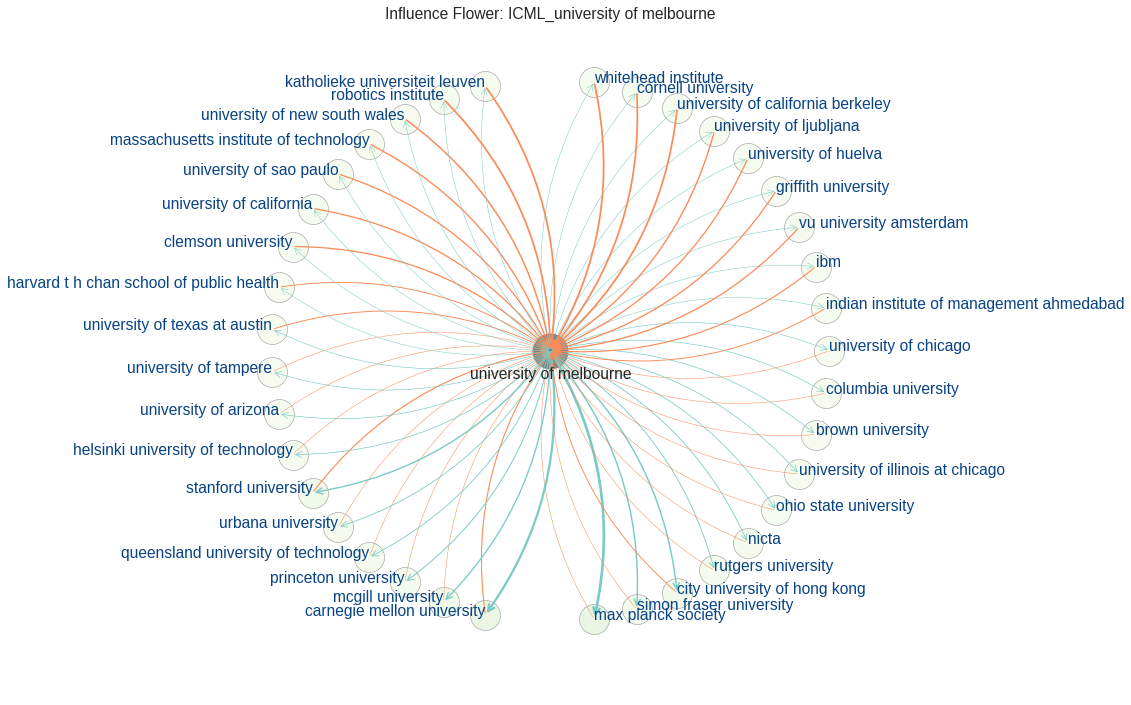

In [21]:
# university_name = "australian national university"
# university_name = "stanford university"
# university_name = "max planck society"
# university_name = "university of sydney"
university_name = "university of melbourne"
# university_name = "university of technology sydney"
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(111)
# ax2 = fig.add_subplot(122)
draw_egocircle_inout(graph=G, ego=university_name, direction="out", ax=ax1, renorm_weights='log', venue_name=venue_name, solid=False)
# draw_egocircle_solid(graph=G, ego=university_name, direction="out", ax=ax2, renorm_weights='log', venue_name=venue_name, solid=False)



# save purpose

In [6]:
# goal 3 -- draw circle layout of incoming/outgoing curved edges plus other edges in the ego net
def draw_egocircle_inout(graph=None, ego=None, ax=None, direction="out", renorm_weights='lin', venue_name='', 
                   max_neighbour = 20, solid=False,
                   plot_setting={'max_marker':30, 'max_line': 25., 'min_line': .5, 'max_link': 3.,
                                 "sns_palette": "RdBu", "out_palette": "OrRd", "in_palette": "GnBu",
                                 "num_colors": 100, "delta_text":0.02}):
    ps = plot_setting
    if not ax:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111)
    sns.set_context("talk", font_scale=1.)
    sns.set_style("white")
    sns.despine()
        
    xroot = 0.
    yroot = 0.

    node_list = graph.nodes()
    in_node_list = set([e[0] for e in graph.in_edges(ego)])
    out_node_list = set([e[1] for e in graph.out_edges(ego)])
    
    if ego in node_list:
        node_list.remove(ego)
    in_weight_list = [graph[n][ego]['weight'] if n in in_node_list else 0 for n in node_list]
    out_weight_list = [graph[ego][n]['weight'] if n in out_node_list else 0 for n in node_list]

    nn = min(len(node_list), max_neighbour)
    
    all_edge_weight = [d['weight'] for (u,v,d) in G.edges(data=True)]
    
    # nomalise these weights to get edge width
    if renorm_weights == 'log':
        weight_max = max( [np.log10(w+1) for w in all_edge_weight])
        weight_min = min( [np.log10(w+1) for w in all_edge_weight])
        in_weight_norm = [ (np.log10(w+1)-weight_min)/(weight_max-weight_min) for w in in_weight_list ]
        out_weight_norm = [ (np.log10(w+1)-weight_min)/(weight_max-weight_min) for w in out_weight_list ]
    elif renorm_weights == 'lin':
        weight_max = max(all_edge_weight)
        weight_min = min(all_edge_weight)
        in_weight_norm = [ (w-weight_min)/(weight_max-weight_min) for w in in_weight_list ]
        out_weight_norm = [ (w-weight_min)/(weight_max-weight_min) for w in out_weight_list ]
    #print(weight_norm, weight_max, weight_min, nn)
    in_node_colors = sns.color_palette(ps['in_palette'], ps['num_colors'])
    out_node_colors = sns.color_palette(ps['out_palette'], ps['num_colors'])
    in_edge_color = in_node_colors[int(ps['num_colors']/2)]
    out_edge_color = out_node_colors[int(ps['num_colors']/2)]
    
    if direction == 'in':
        isort = np.argsort(in_weight_list)[::-1]
        weight_norm = in_weight_norm
        node_colors = in_node_colors
    else:
        isort = np.argsort(out_weight_list)[::-1]
        weight_norm = out_weight_norm
        node_colors = out_node_colors
    
    anglelist = np.linspace(0.95*np.pi, 0.05*np.pi,  num=nn)
    node_pos = [()]* len(node_list)
    for i, jn in enumerate(isort[:nn]):
        w = weight_norm[jn]
        # node position
        xp = np.sin(np.abs(anglelist[i])) * ((-1)**(i%2))
        yp = np.cos(anglelist[i])
        node_pos[jn] = (xp, yp)
        
        # calculate node color index based on its weight
        ci = int( w*(len(node_colors)-1e-3) )
        lw = ps['max_line'] * w + ps['min_line']
        # plot the node
        ax.plot(xp, yp, 'o', c=node_colors[ci], markersize= ps['max_marker'], # markersize=int(sz), 
            alpha=.9, mec='0.5', mew=.5) 
        
    for i, jn in enumerate(isort[:nn]):
        n = node_list[jn]
        in_w = in_weight_norm[jn]
        out_w = out_weight_norm[jn]
        # node position
        xp = np.sin(np.abs(anglelist[i])) * ((-1)**(i%2))
        yp = np.cos(anglelist[i])

        in_ci = int( in_w*(len(in_node_colors)-1e-3) )
        out_ci = int( out_w*(len(out_node_colors)-1e-3) )
        in_lw = ps['max_line'] * in_w + ps['min_line']
        out_lw = ps['max_line'] * out_w + ps['min_line']
        if direction == 'out':
            # out is over in
            ax.annotate("", xy=(xroot, yroot), xycoords='data',
                xytext=(xp, yp), textcoords='data',
                arrowprops=dict(arrowstyle = '<-', 
                            color=in_edge_color, linewidth = in_lw,
                            connectionstyle="arc3,rad=0.2", ), )
            ax.annotate("", xy=(xp, yp), xycoords='data',
                xytext=(xroot, yroot), textcoords='data',
                arrowprops=dict(arrowstyle = '<-', 
                            color=out_edge_color, linewidth = out_lw,
                            connectionstyle="arc3,rad=0.2", ), )
        else:
            # in is over out
            ax.annotate("", xy=(xp, yp), xycoords='data',
                xytext=(xroot, yroot), textcoords='data',
                arrowprops=dict(arrowstyle = '<-', 
                            color=out_edge_color, linewidth = out_lw,
                            connectionstyle="arc3,rad=0.2", ), )
            ax.annotate("", xy=(xroot, yroot), xycoords='data',
                xytext=(xp, yp), textcoords='data',
                arrowprops=dict(arrowstyle = '<-', 
                            color=in_edge_color, linewidth = in_lw,
                            connectionstyle="arc3,rad=0.2", ), )
            
        # add node text
        h = ax.text(xp, yp, n, horizontalalignment=['left', 'right'][i%2], color=node_colors[-1])
        
    ax.plot(xroot, yroot, 'o', c=[.5, .5, .5], markersize=1.2*ps['max_marker'], fillstyle='full', mec='0.5')
    ax.text(xroot, yroot-5*ps['delta_text'], ego, horizontalalignment='center')

    ax.set_xlim((-1.2, 1.2))
    ax.set_ylim((-1.2, 1.2))
    ax.axis('off')
    ax.title.set_text("Influence Flower: " + venue_name+'_'+university_name)
    

In [7]:
# goal 4 -- draw solid circle with edges in the ego net
def draw_egocircle_solid(graph=None, ego=None, ax=None, direction="out", renorm_weights='lin', venue_name='', 
                   max_neighbour = 20, solid=False,
                   plot_setting={'max_marker':30, 'max_line': 25., 'min_line': .5, 'max_link': 3.,
                                 "sns_palette": "RdBu", "out_palette": "OrRd", "in_palette": "GnBu",
                                 "num_colors": 100, "delta_text":0.02}):
    ps = plot_setting
    if not ax:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111)
    sns.set_context("talk", font_scale=1.)
    sns.set_style("white")
    sns.despine()
        
    xroot = 0.
    yroot = 0.

    node_list = graph.nodes()
    in_node_list = set([e[0] for e in graph.in_edges(ego)])
    out_node_list = set([e[1] for e in graph.out_edges(ego)])
    if ego in node_list:
        node_list.remove(ego)
    in_weight_list = [graph[n][ego]['weight'] if n in in_node_list else 0 for n in node_list]
    out_weight_list = [graph[ego][n]['weight'] if n in out_node_list else 0 for n in node_list]
#     in_node_colors = sns.color_palette(ps['in_palette'], ps['num_colors'])
#     out_node_colors = sns.color_palette(ps['out_palette'], ps['num_colors']) 

#     if direction == "in":
#         node_list = [e[0] for e in graph.in_edges(ego)]
#         if ego in node_list:
#             node_list.remove(ego)
#         weight_list = [graph[n][ego]['weight'] for n in node_list]
#         node_colors = sns.color_palette(ps['in_palette'], ps['num_colors'])
#     else:
#         node_list = [e[1] for e in graph.out_edges(ego)]
#         if ego in node_list:
#             node_list.remove(ego)
#         weight_list = [graph[ego][n]['weight'] for n in node_list]
#         node_colors = sns.color_palette(ps['out_palette'], ps['num_colors'])    
#    print(weight_list)
    nn = min(len(node_list), max_neighbour)
    all_edge_weight = [d['weight'] for (u,v,d) in G.edges(data=True)]
    
    # nomalise these weights to get edge width
    if renorm_weights == 'log':
        weight_max = max( [np.log10(w+1) for w in all_edge_weight])
        weight_min = min( [np.log10(w+1) for w in all_edge_weight])
        in_weight_norm = [ (np.log10(w+1)-weight_min)/(weight_max-weight_min) for w in in_weight_list ]
        out_weight_norm = [ (np.log10(w+1)-weight_min)/(weight_max-weight_min) for w in out_weight_list ]
    elif renorm_weights == 'lin':
        weight_max = max(all_edge_weight)
        weight_min = min(all_edge_weight)
        in_weight_norm = [ (w-weight_min)/(weight_max-weight_min) for w in in_weight_list ]
        out_weight_norm = [ (w-weight_min)/(weight_max-weight_min) for w in out_weight_list ]
    #print(weight_norm, weight_max, weight_min, nn)
    in_node_colors = sns.color_palette(ps['in_palette'], ps['num_colors'])
    out_node_colors = sns.color_palette(ps['out_palette'], ps['num_colors'])
    in_edge_color = in_node_colors[int(ps['num_colors']/2)]
    out_edge_color = out_node_colors[int(ps['num_colors']/2)]
    
    if direction == 'in':
        isort = np.argsort(in_weight_list)[::-1]
        weight_norm = in_weight_norm
        node_colors = in_node_colors
    else:
        isort = np.argsort(out_weight_list)[::-1]
        weight_norm = out_weight_norm
        node_colors = out_node_colors
        
    # sort order of edges based on the weight 
    
    anglelist = np.linspace(0.95*np.pi, 0.05*np.pi,  num=nn)
    node_pos = [()]* len(node_list)
    for i, jn in enumerate(isort[:nn]):
        w = weight_norm[jn]
        # node position
        xp = np.sin(np.abs(anglelist[i])) * ((-1)**(i%2))
        yp = np.cos(anglelist[i])
        node_pos[jn] = (xp, yp)
        
        # calculate node color index based on its weight
        ci = int( w*(len(node_colors)-1e-3) )
        lw = ps['max_line'] * w + ps['min_line']
        # plot the node
        ax.plot(xp, yp, 'o', c=node_colors[ci], markersize= ps['max_marker'], # markersize=int(sz), 
            alpha=.9, mec='0.5', mew=.5) 
    
    for i, j in itertools.permutations([i for i in isort[:nn]], r=2):
        # draw edge if exists
        if node_list[j] in graph[node_list[i]]:
            w = graph[node_list[i]][node_list[j]]['weight']
            lw = ps['max_link'] * w + ps['min_line']

            ax.annotate("", xy = node_pos[i], xycoords='data',
                xytext = node_pos[j], textcoords='data',
                arrowprops=dict(arrowstyle="-", #linestyle="dashed",
                                color = (.5, .5, .5), linewidth= lw,
                                connectionstyle="arc3,rad=0.12", ), )
    for i, jn in enumerate(isort[:nn]):
        n = node_list[jn]
        xp = np.sin(np.abs(anglelist[i])) * ((-1)**(i%2))
        yp = np.cos(anglelist[i])
        h = ax.text(xp, yp, n, horizontalalignment=['left', 'right'][i%2], color=node_colors[-1])
#     ax.plot(xroot, yroot, 'o', c=[.5, .5, .5], markersize=1.2*ps['max_marker'], fillstyle='full', mec='0.5')
#     ax.text(xroot, yroot-5*ps['delta_text'], ego, horizontalalignment='center')

    ax.set_xlim((-1.2, 1.2))
    ax.set_ylim((-1.2, 1.2))
    ax.axis('off')
    ax.title.set_text("Influence Ball: " + venue_name+'_'+university_name)
    